## Model problem


In [1]:
include("../src/variationaltimedisc.jl")
using GradientRobustMultiPhysics
using ExtendableGrids
using Printf
using ExtendableSparse
using DelimitedFiles
using SimplexGridFactory
using Triangulate

Examples:

In [2]:
function get_flow_data(ν, example)
  ## note that dependencies "XT" marks the function to be x- and t-dependent
  ## that causes the solver to automatically reassemble associated operators in each time step
  u = DataFunction((result, x, t) -> (
    result[1] =  2*x[1]*x[2]*cos(10 * π * t); 
    result[2] = -3*x[1]^2* sin(10 * π * t) - x[2]^2 * cos(10*π * t);
    ), [2,2]; name = "u", dependencies = "XT", bonus_quadorder = 5)
  u_t = DataFunction((result, x, t) -> (
    result[1] = -20*π*x[1]*x[2]*cos(10 * π * t); 
    result[2] = -30*π*x[1]^2* cos(10 * π * t) + 10*π*x[2]^2 * sin(10*π * t);
    ), [2,2]; name = "u", dependencies = "XT", bonus_quadorder = 5)
  p = DataFunction((result, x, t) -> (
#       result[1] = -(x[1]^2 + x[2]^2 - 2.0/3.0)*(1.5 + 0.5 * t^(3/4))
    result[1] = -(x[1]^3 + x[2]^3 - 0.5)*(1.5 + 0.5 * sin(10 * π * t))
    ), [1,2]; name = "p", dependencies = "XT", bonus_quadorder = 5)

  ############## common code for all examples #####
  dt_u = eval_dt(u)
  Δu = eval_Δ(u)
  ∇p = eval_∇(p)
  f = DataFunction((result, x, t) -> (
        result .= dt_u(x,t) .- ν*Δu(x,t) .+ view(∇p(x,t),:);
      ), [2,2]; name = "f", dependencies = "XT", bonus_quadorder = 5)  
  return u, p, f, u_t
end

get_flow_data (generic function with 1 method)

In [3]:
# function for error computations
function ErrorComputation(TDisc, SystemSol, PPData, 
  u, p, dt_u, eu_max, Solution, order, t0, tau, rec_space, do_post_processing=false)
  nQF = TDisc.nQF
  pQF = TDisc.pQF
  KAPW = TDisc.KAPW
  kL = TDisc.kL
  kR = TDisc.kR
  DerivL = TDisc.DerivL
  DerivR = TDisc.DerivR
  CorrPW = TDisc.CorrectionPW
  CorrR  = TDisc.CorrectionR
  d = order + 1 - kL
  di = d - kR
  ndofu = length(Solution[1])
  ndofp = length(Solution[2])
  N = ndofu + ndofp  

  discsol = zeros(Float64, N, order+1)
  discsolPW = zeros(Float64, N, nQF+1)
  PPDelta = zeros(Float64, N)
  discsol[:] = reshape(SystemSol.entries, N, d)
  discsolPW[:] = discsol * KAPW

  if do_post_processing
    PPDelta[:] = discsol * DerivL[:,1] - PPData[:]
    temp = PPDelta[:]*CorrPW[1,:]'
    discsolPW[:] = discsolPW[:] - temp[:]
  end

  errorH1 = zeros(Float64, nQF); errorL2 = zeros(Float64, nQF)
  errorL2P = zeros(Float64, nQF); errorH1P = zeros(Float64, nQF)
  L2Error_u = zero(Float64); H1Error_u = zero(Float64)
  l2erp = zero(Float64); h1erp = zero(Float64)
  errorH1L2 = zeros(Float64, nQF)
  l2recons = zero(Float64)
  errorRecons = zeros(Float64, nQF)
  # loop over discrete time points
  for i = 1 : nQF 
    ti = t0 + tau * (pQF[i]+1)/2
    L2Error_u = L2ErrorIntegrator(u, Identity; time = ti)
    H1Error_u = L2ErrorIntegrator(∇(u), Gradient; time = ti)
    l2recons = L2ErrorIntegrator(u, ReconstructionIdentity{rec_space}; time = ti)
    for j = 1 : ndofu
      Solution[1][j] = discsolPW[j, i]
    end
    l2u = evaluate(L2Error_u, Solution[1])
    errorL2[i] = l2u
    h1u = evaluate(H1Error_u, Solution[1])
    errorH1[i] = h1u
    l2r = evaluate(l2recons, Solution[1])
    errorRecons[i] = l2r
    if !do_post_processing
      for j = 1 : ndofp
        Solution[2][j] = discsolPW[j+ndofu, i]
      end
      pmean = ItemIntegrator([Identity])
      mv = evaluate(pmean, Solution[2])
      for j = 1 : ndofp
        Solution[2][j] -= mv
      end
      l2erp = L2ErrorIntegrator(p, Identity; time=ti)
      l2erp = evaluate(l2erp,   Solution[2])
      h1erp = L2ErrorIntegrator(∇(p), Gradient; time = t0 + tau)
      h1erp = evaluate(h1erp, Solution[2])
      errorL2P[i] = l2erp
      errorH1P[i] = h1erp
    end
  end
  ## errors at discrete time points
  for j = 1 : ndofu 
    Solution[1][j] = SystemSol[2*di+1][j]
  end
  l2er = L2ErrorIntegrator(u, Identity; time=t0+tau)
  l2er = evaluate(l2er,   Solution[1])
  h1er = L2ErrorIntegrator(∇(u), Gradient; time=t0+tau)
  h1er = evaluate(h1er,   Solution[1])
  eu_max = max(eu_max, l2er)
  if !do_post_processing
    for j = 1 : ndofp 
      Solution[2][j] = SystemSol[2*di + 2][j]
    end
    pmean = ItemIntegrator([Identity])
    mv = evaluate(pmean, Solution[2])
    for j = 1 : ndofp
      Solution[2][j] -= mv
    end
    l2erp = L2ErrorIntegrator(p, Identity; time=t0 + tau)
    l2erp = evaluate(l2erp, Solution[2])
    h1erp = L2ErrorIntegrator(∇(p), Gradient; time = t0 + tau)
    h1erp = evaluate(h1erp, Solution[2])
  end

  # error computation for time derivatives
  KADerPW = TDisc.KA1PW
  CorrDPW = TDisc.CorrectionDerivPW
  discsolPW[:] = discsol * KADerPW
  if do_post_processing
    temp = PPDelta[:]*CorrDPW[1,:]'    
    discsolPW[:] = discsolPW[:] - temp[:]
  end
  discsolPW ./= (tau/2)

  for i = 1 : nQF
    ti = t0 + tau * (pQF[i]+1)/2    
    l2dtu = L2ErrorIntegrator(dt_u, Identity; time = ti)
    for j = 1 : ndofu
      Solution[1][j] = discsolPW[j, i]
    end
    l2dtu = evaluate(l2dtu, Solution[1])
    errorH1L2[i] = l2dtu
  end

  if do_post_processing
    PPData[:] = discsol * DerivR[:,1]
    PPData[:] -= PPDelta[:]*CorrR[1,1]
  end
  return errorL2, errorH1, errorL2P, errorH1P, eu_max, errorH1L2, PPData, errorRecons
end

ErrorComputation (generic function with 2 methods)

In [4]:
function run_main(;time_order = 1, scheme = 0, ν = 1, nlevels=2, fe_type = 1, rec_type = 1, T0 = 0, end_time=1, 
  nsteps=10, reconstruct = true, example = 1, verbosity = 0)
  
  # set log level
  set_verbosity(verbosity)
  ## initial grid 
  #xgrid = grid_unitsquare(Triangle2D)
  # refine the grid 
  #xgrid = uniform_refine(xgrid, nlevels)  
  xgrid = simplexgrid(Triangulate;
            points=[0 0 ; 0 1 ; 1 1 ; 1 0]',
            bfaces=[1 2 ; 2 3 ; 3 4 ; 4 1 ]',
            bfaceregions=[1, 2, 3, 4],
            regionpoints=[0.5 0.5;]',
            regionnumbers=[1],
            regionvolumes=[4.0^(-nlevels-1)/2])
  println(xgrid)

  ## choose one of these (inf-sup stable) finite element type pairs
  FETypes = [H1P2{2,2}, H1P1{1}] # Taylor-Hood elements
  ## P2-bubble element + reconstruction operator
  FETypes = [H1P2B{2,2}, L2P1{1}];
  ## BR
  FETypes = [H1BR{2}, L2P0{1}]
  if fe_type == 2
    FETypes = [H1P2B{2,2}, L2P1{1}];
  end

  rec_space = HDIVRT0{2}
  if fe_type == 1 && rec_type == 1
    rec_space = HDIVRT0{2}
  elseif fe_type == 1 && rec_type == 2
    rec_space = HDIVBDM1{2}
  elseif fe_type == 2 && rec_type == 1
    rec_space = HDIVRT1{2}
  elseif fe_type == 2 && rec_type == 2
    rec_space = HDIVBDM2{2}
  end
  println(FETypes)
  println(rec_space)
  test_operator = reconstruct ? ReconstructionIdentity{rec_space} : Identity
  ## negotiate data functions to the package  
  u, p, f, dt_u = get_flow_data(ν, example)
  ## choose the time discretization 
  TDisc = VariationalTimeDisc.SetVariationalTimeDisc(Float64,time_order, scheme)  
  
  # println(xgrid)
  # generate FE spaces
  FES = [FESpace{FETypes[1]}(xgrid), FESpace{FETypes[2]}(xgrid)]
  # solution vector
  Solution = FEVector(["u_h", "p_h"], FES)

  ndofu = FES[1].ndofs
  ndofp = FES[2].ndofs
  # n_unknown = length(Solution.entries)  
  GradientRobustMultiPhysics.interpolate!(Solution[1], u; time = 0.)
  BAP_L2_u = L2BestapproximationProblem(u; bestapprox_boundary_regions = [1,2,3,4])
  
  BA_L2_u = FEVector("Πu",FES[1])
  solve!(BA_L2_u, BAP_L2_u)
#   Solution[1][:] = BA_L2_u.entries
  initSol = zeros(Float64, ndofu)
  initSol = Solution.entries # full solution
  # mass matrix 
  M = FEMatrix{Float64}(FES)
  assemble_operator!(M[1,1], BilinearForm([test_operator, Identity]))
  # velocity pressure matrices
  A = FEMatrix{Float64}(FES)
  assemble_operator!(A[1,1], LaplaceOperator(ν))
  assemble_operator!(A[1,2], LagrangeMultiplier(Divergence); At = A[2,1]) 

  rhs = FEVector{Float64}(FES)
  assemble_operator!(rhs[1], LinearForm(test_operator, f); time=0.0)
  #=
  declarations for the time Discretization 
  =#
  r = time_order
  k = scheme
  kL = TDisc.kL
  kR = TDisc.kR
  qp = TDisc.p
  MassCoeffs = TDisc.MassCoeffs
  StiffCoeffs = TDisc.StiffCoeffs
  IC = TDisc.IC
  nQF = TDisc.nQF
  wQF = TDisc.wQF
  t0 = T0
  tau = (end_time - T0)/nsteps  
  ###
  # data for post processing
  pp = TDisc.pp
  PPData = zeros(Float64, ndofu+ndofp)
  PPData[:] = initSol
  PPData[:] *= (tau/2)^pp
  ###  
  V1 = zeros(Float64, ndofu, r+1)  
  SysFES = Array{FESpace{Float64, Int32}, 1}([])
  for j=1:r+1-k
    append!(SysFES, FES)
  end
  SystemMatrix = FEMatrix{Float64}(SysFES)
  # @show SystemMatrix
  SystemRHS = FEVector{Float64}(SysFES)
  SystemSol = FEVector{Float64}(SysFES)
  # number of solution vectors to be calculated
  d = r+1-kL
  # Number of inner solution vectors
  di = d-kR
  # println(d, " ", di)
  dt = Array{BoundaryData,1}(undef,0)
  push!(dt,BoundaryData(BestapproxDirichletBoundary; regions = [1,2,3,4], data=u))
  # pp = GridVisualizer(; Plotter = PyPlot, layout = (2,2), clear = true, resolution = (1000,500))
  ##########################################  
  eL2 = zero(Float64); eL2P = zero(Float64); eH1P = zero(Float64); errorL2P = zeros(Float64, nQF)
  errorH1P = zeros(Float64, nQF); errorL2 = zeros(Float64, nQF); eH1 = zero(Float64)
  errorH1 = zeros(Float64, nQF)
  errorL2_PP = zeros(Float64, nQF); errorH1_PP =  zeros(Float64, nQF)
  eL2_PP= zero(Float64); eH1_PP = zero(Float64)
  eu_max = -one(Float64); eH1L2 = zero(Float64); eH1L2PP = zero(Float64)
  eu_recon = zero(Float64)
  eu_reconPP = zero(Float64)
  L2L2_recon = zeros(Float64)
  L2L2_reconPP = zeros(Float64)
  errors=[]
  
  BAP_L2_p = L2BestapproximationProblem(p; bestapprox_boundary_regions = [])
  add_constraint!(BAP_L2_p, FixedIntegralMean(1,0))
  ##########################################
  # time loop 
  for current_time = 1 : nsteps
    @printf("Time step: %d: [%.5f, %.5f]\n", current_time, t0, t0+tau)
    # preparation of the right hand side         
    if kL > 0 # no dG
      V1[:, 1] = rhs.entries
    end
    # inner quad points
    for i = 1 : r - k
      fill!(rhs.entries, 0)
      assemble_operator!(rhs[1], LinearForm(test_operator, f), time = t0 + tau * (qp[i]+1)/2)
      V1[:,i + kL] = rhs[1][:] 
      # println(rhs[1])
    end
    fill!(rhs.entries, 0)
    assemble_operator!(rhs[1], LinearForm(test_operator, f), time = t0 + tau)
    # println(rhs[1])
    V1[:, 1+(r+1-kR)] = rhs[1][:]
    # println("V1: ", V1)
    # mass matrix times solution for velocity
    # Mu0[:] = M[1,1]*Solution[1]
    if k>0
      Mu0 = zeros(Float64, ndofu, kL)
    else
      Mu0 = zeros(Float64, ndofu)
    end
    # mass matrix time the initial solution 
    addblock_matmul!(Mu0, M[1,1], Solution[1]) #; factor = 1) 
    # preparation of the system right hand side 
    fill!(SystemRHS.entries, 0)
    for i = 1 : r+1-k
      if k>0
        addblock!(SystemRHS[2*i-1], Mu0 * MassCoeffs[i, 1:kL]; factor= - 1.0)
        addblock!(SystemRHS[2*i-1], A.entries * Solution[1].entries; factor= - tau/2 * StiffCoeffs[i, 1])
      else
        addblock!(SystemRHS[2*i-1], Mu0; factor= IC[i])
      end
    end
    for i= 1 : r+1-k
      addblock!(SystemRHS[2*i-1], V1 * StiffCoeffs[i, :]; factor= tau/2 )
    end    
    # reset the system matrix
    fill!(SystemMatrix.entries.cscmatrix.nzval, 0)
    # putting everything together for the left hand side 
    for s1 = 1 : di + 1
      fill!(A[1,1], 0)
      assemble_operator!(A[1, 1], LaplaceOperator(ν); time= t0 + tau * (qp[s1] +1) / 2. )
      for s2 = 1 : r + 1 - k
        addblock!(SystemMatrix[2*s2-1, 2*s1-1], M[1, 1]; factor= MassCoeffs[s2, s1+kL])
        if (s1 == s2)
          addblock!(SystemMatrix[2*s2-1, 2*s1-1], A[1, 1]; factor= StiffCoeffs[s2, s1+kL] * tau / 2)
          ## set the correct rows and cols
          addblock!(SystemMatrix[2*s2-1, 2*s1], A[1, 2]; factor= StiffCoeffs[s2, s1+kL] * tau / 2)
          addblock!(SystemMatrix[2*s2, 2*s1-1], A[2, 1]; factor= StiffCoeffs[s2, s1+kL] * tau / 2)
        end
      end
    end
    # @show SystemMatrix
    # @show SystemRHS.entries
    for i = 1 : r+1-k
      dofs = boundarydata!(SystemSol[2*i-1], dt; time = t0 + tau * (qp[i]+1)/2)
      # println("dofs: ", dofs)
      for dof in dofs
        SystemRHS[2*i-1][dof] = 1e60 * SystemSol[2*i-1][dof]
        SystemMatrix[2*i-1,2*i-1][dof,dof] = 1e60
      end
      SystemMatrix[2*i,2*i][1,1] = 1e60 #pressure correction
    end
    flush!(SystemMatrix.entries)
    SystemSol.entries[:] = SystemMatrix.entries \ SystemRHS.entries
    # Error Computation
    errorL2, errorH1, errorL2P, errorH1P, eu_max, errorH1L2, _, L2L2_recon = 
          ErrorComputation(TDisc, SystemSol, PPData, u, p, dt_u, eu_max, 
          Solution, r, t0, tau, rec_space, false)
    eL2 = eL2 + errorL2' * wQF * tau/2.0
    eH1 = eH1 + errorH1' * wQF * tau/2.0
    eL2P = eL2P + errorL2P' * wQF * tau/2.0
    eH1P = eH1P + errorH1P' * wQF * tau/2.0
    eH1L2 = eH1L2 + errorH1L2' * wQF * tau/2.0
    eu_recon = eu_recon + L2L2_recon' * wQF * tau/2.0
    println("L2L2u: ", sqrt(eL2), " L2H1u: ", sqrt(eH1), " L2L2p: ", sqrt(eL2P), 
            " L2H1p: ", eH1P, " H1L2u: ", sqrt(eH1L2), " L2(Recons): ", sqrt(eu_recon))
    errorL2_PP, errorH1_PP, _, _, _, errorH1L2PP, PPData, L2L2_reconPP = 
          ErrorComputation(TDisc, SystemSol, PPData, u, p, dt_u, eu_max, 
          Solution, r, t0, tau, rec_space, true)
    eL2_PP = eL2_PP + errorL2_PP' * wQF * tau/2.0
    eH1_PP = eH1_PP + errorH1_PP' * wQF * tau/2.0
    eH1L2PP = eH1L2PP + errorH1L2PP' * wQF * tau/2.0
    eu_reconPP = eu_reconPP + L2L2_reconPP' * wQF * tau/2.0
    println("PPL2L2u: ", sqrt(eL2_PP), " PPL2H1u: ", sqrt(eH1_PP), 
    " PPH1L2u: ", sqrt(eH1L2PP), " L2(ReconsPP): ", sqrt(eu_reconPP))
    # solve the best approximation problem at final time
    #BA_L2_p = FEVector("L2-Bestapproximation pressure",FES[2])
    #solve!(BA_L2_p, BAP_L2_p)
    #L2ErrorEvaluator = L2ErrorIntegrator(p, Identity)
    #L2errorp = sqrt(evaluate(L2ErrorEvaluator,BA_L2_p))
    #println("L2errp: ", L2errorp)
    ## copy solution for the next time step
    for j = 1 : ndofu 
      Solution[1][j] = SystemSol[2*di+1][j]
    end
    # throw(error)    
    t0 = t0 + tau
  end# endfor time loop
  (eL2, eH1, eL2P, eH1P, eH1L2, eu_max, eu_recon, eL2_PP, eH1_PP, eH1L2PP, eu_reconPP)
  
  # writedlm("../../papers/dGPressureRobust/results/"*filename, errors)
end #end main

run_main (generic function with 1 method)

In [5]:
function conv_test(ns, td=1, tdorder=0, ν=1e-5, nl=2, fe_t=2, rec=2, recons=true )

  taus = []
  eL2s=[]; eH1s=[]; eL2Ps=[]; eH1Ps=[]
  eH1L2s=[]; eu_maxs=[]; eu_recons=[]; eL2_PPs=[];
  eH1_PPs=[]; eH1L2PPs=[]; eu_reconPPs=[]

  println("Here I am ")
  for n in ns
    # time_order = 1, scheme = 0, ν = 1, nlevels=2, fe_type = 1, rec_type = 1, T0 = 0, end_time=1, 
    # nsteps=10, reconstruct = true, example = 1, verbosity = 0
    eL2, eH1, eL2P, eH1P, eH1L2, eu_max, eu_recon, eL2_PP, eH1_PP, eH1L2PP, eu_reconPP  = run_main(time_order = td, scheme = tdorder, ν = ν, nlevels=nl, fe_type = fe_t, rec_type = rec, nsteps=n)
    tau = n

    push!(eL2s, eL2); push!(eH1s,eH1);push!(eL2Ps,eL2P); push!(eH1Ps, eH1P);
    push!(eH1L2s, eH1L2); push!(eu_maxs,eu_max); push!(eu_recons,eu_recon);
    push!(eL2_PPs,eL2_PP); push!(eH1_PPs, eH1_PP); push!(eH1L2PPs, eH1L2PP); 
    push!(eu_reconPPs,eu_reconPP)
    push!(taus,tau) 
  end
  (eL2s, eH1s, eL2Ps, eH1Ps, eH1L2s, eu_maxs, eu_recons, eL2_PPs, eH1_PPs, eH1L2PPs, eu_reconPPs, taus)

end

conv_test (generic function with 8 methods)

In [6]:
eL2s, eH1s, eL2Ps, eH1Ps, eH1L2s, eu_maxs, eu_recons, eL2_PPs, eH1_PPs, eH1L2PPs, eu_reconPPs, taus = conv_test([10,20,40,80,160]);

Here I am 
ExtendableGrid{Float64, Int32};
dim: 2 nodes: 115 cells: 194 bfaces: 34


DataType[H1P2B{2,2}, L2P1{1}]
HDIVBDM2{2}

VariationalTimeDisc(r=1, k=0): dG(1)
┌ Warning:  30161226 allocations during ITEMTYPE_FACE volume calculation
└ @ ExtendableGrids ~/.julia/packages/ExtendableGrids/XFxI3/src/derived.jl:937
┌ Info: ========== Solving L2-Bestapproximation problem (at fixed time 0) ==========
└ 	Equation (1.1) L2-bestapproximation equation for u (discretised by H1P2B{2,2}, ndofs = 1234)
[ Info: overall residual = 1.021392306421728e-17
[ Info: Computing interior reconstruction coefficients for H1P2B{2,2} > HDIVBDM2{2} (ON_CELLS)
Time step: 1: [0.00000, 0.10000]
L2L2u: 0.2009457352960444 L2H1u: 4.105708185118924 L2L2p: 1.0851240234911772 L2H1p: 21.253310403278682 H1L2u: 12.685300952373604 L2(Recons): 0.20128707773232116
PPL2L2u: 0.0643319086665413 PPL2H1u: 2.7289650585428307 PPH1L2u: 7.087839797686736 L2(ReconsPP): 0.0648891781471588
Time step: 2: [0.10000, 0.20000]
L2L2u: 0.293477

[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
L2uAny[0.4319189869367896, 0.02637040335224773, 0.0017031983615818749, 0.00010735539909486007, 6.723708418892635e-6]
L2pAny[11.773744402090726, 1.475284940401558, 0.09822953547934332, 0.006241753901567761, 0.000398785703935498]
H1L2uAny[1615.390780977942, 558.6759742984628, 441.6814284673773, 425.03379579903293, 428.05021651773615]
LinfAny[0.07760393215669437, 0.0013289097412755547, 2.2747406808131727e-5, 3.864407373058932e-7, 6.3774566174192174e-9]


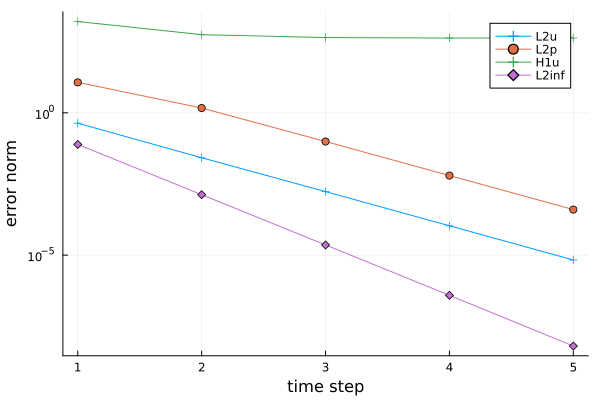

In [7]:
using Plots
println("L2u", eL2s)
println("L2p", eL2Ps)
println("H1L2u", eH1L2s)
println("Linf", eu_maxs)
taus = [1, 2, 3, 4, 5 ]
plot(taus,[eL2s eL2Ps eH1L2s eu_maxs],
    yaxis=:log10,
    label=["L2u" "L2p" "H1u" "L2inf"],
    shape=:auto,
    xlabel="time step",ylabel="error norm")

L2uAny[0.06903407854871836, 0.0018616846793384422, 3.034827851448162e-5, 4.875935811759391e-7, 7.747192621231725e-9]
L2pAny[224.2350406136285, 7.981163195690291, 0.1383004475381146, 0.002360074242544005, 3.900506298122074e-5]
H1L2uAny[506.42865635828696, 462.1898522534394, 440.9783391585098, 438.8890836579756, 438.6754853678897]
LinfAny[0.07046022961576255, 0.0019377951501585965, 3.1967334919032145e-5, 5.191826649611905e-7, 8.30902516536423e-9]


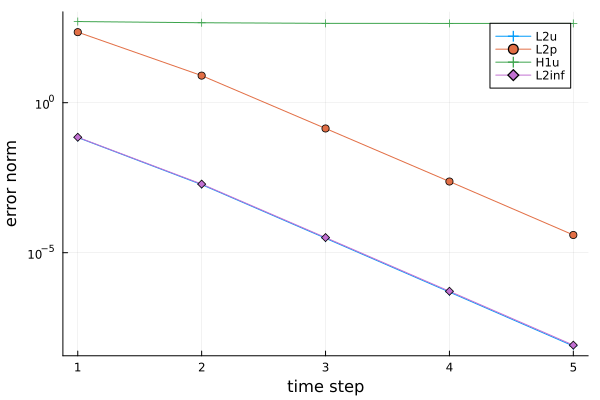

In [9]:
println("L2u", eL2_PPs)
println("L2p", eH1_PPs)
println("H1L2u",eH1L2PPs)
println("Linf", eu_reconPPs)
taus = [1, 2, 3, 4, 5 ]
plot(taus,[eL2_PPs eH1_PPs eH1L2PPs eu_reconPPs],
    yaxis=:log10,
    label=["L2u" "L2p" "H1u" "L2inf"],
    shape=:auto,
    xlabel="time step",ylabel="error norm")